# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [2]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Well, ICA discovers underlying statistically independent causes. So, while it is the case that our data consists of the yearly net price of all products in various categories ordered by stores, there may be independent trends consisting of combinations of the categories that get revealed, corresponding to maybe a part of a store or type of store or independent variance attributable to geographic position. In the context of our lesson, we may find a component that corresponds to some shared property of small stores that might help us solve our dilemma. PCA will find the best way to describe many features in terms of lesser amounts of new features which are rotations of the old ones. So it'll tell me what, in essence, a store is like, and the best first correction to that.  I don't expect the PCA components themsleves to be too useful by itself, since here the large customers will indeed swamp out the smaller ones.

###PCA

In [3]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(copy=True)
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

It drops off quite quickly after the first two components. The first two components jointly describe about 85% of the variance. The cliff after the second principal component seems to suggest the second PC a good cutoff point; the components afterwards aren't explaining very much variance.

**3)** What do the dimensions seem to represent? How can you use this information?

The first dimension, at least, can be interpreted as the typical store ratio of orders.  What I mean by that is that if we consider all possible feature vectors, this is the one that gets closest to describing the data by itself, up to a constant multiplier. The first two are then just the two feature vectors that do as above.  Now, since the larger customers tend to drown out the smaller ones, it makes perfect sense that this first PCA component is representative of larger customers.  The component consists almost entirely of the Fresh category, along with a small positive correlation with the other categories as well, which seems representative of the ordering profile of a restaurant or anywhere else food is prepared, with its very strong focus on Fresh ingredients (Or rather, the opposite of all this since the largest parts of the PCA components are all negative).

The second category, however has a different interpretation.  It's three most prominent components are Grocery, Milk, and Paper/Detergents, in that order.  Those things sound exactly like what you got to a small corner store or small grocery store to get, it has a negative correlation for frozen and fresh because a small store like that may not have space for these things.  

Thus, despite what I initially thought would be the case, PCA does seem to indentify small stores, simply as the second PCA component and not the first one.  The first PCA component seems to be an indication of what larger customers are like, and the second one an indication of what smaller ones are like.

###ICA

In [4]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler

# Adjusting data to have zero mean
data_mean = np.mean(data)
data_std = np.std(data)
adjusted_data = data - data_mean

# Just making sure we did this right...
np.testing.assert_allclose(np.mean(adjusted_data) , np.zeros(6), atol=1.0e-10)

def reorder_rescale(mat, multiplier=1):
    """
    Reorders the rows of the matrix mat so that all of the maximal (in the absolute sense)
    values of each row lie on the main diagonal of the matrix, and normalizes the signs of 
    the rows such that the main diagonal of the component matrix is positive, for the sake
    of readability
    """
    indices = []
    retMatrix = []
    for row in mat:
        max = 0.
        ele_num = -1
        for n, ele in enumerate(row):
            if abs(ele) >= max:
                max = abs(ele)
                ele_num = n
        retMatrix.append(row)       
        indices.append(ele_num)
    rowOrder = []
    for n in range(len(indices)):
        if n in indices:
            rowOrder.extend([a for a, b in enumerate(indices) if b == n])
    retMatrix = (np.array(retMatrix)*multiplier)[rowOrder]
    for k, row in enumerate(retMatrix):
        retMatrix[k] /= retMatrix[k][indices[rowOrder[k]]]
    return retMatrix

def has_unit_diagonal(matrix):
    size = len(matrix)
    tol = 10**(-8)
    for n in range(size):
        if abs(matrix[n][n]-1) > tol:
            return False
    return True

def run_ica(times=5):
    import random
    means = [[0 for x in range(6)] for x in range(6)]
    stds = [[0 for x in range(6)] for x in range(6)]
    component_matrix_array = []
    for x in range(times):
        ica = FastICA(random_state=random.randint(0,2**16))
        source_data = ica.fit_transform(adjusted_data)
        source_data_std = np.std(source_data, axis=0)
        component_matrix_array.append(reorder_rescale(ica.components_, [x/source_data_std[n] for n,x in enumerate(data_std)]))
    
    
    component_matrix_array = [x for x in component_matrix_array if has_unit_diagonal(x)]
    times = len(component_matrix_array)
    
    #Find Mean
    for matrix in component_matrix_array:
        for n, row in enumerate(matrix):
            for m, element in enumerate(row):
                means[n][m] += (element/times)

    #Find STD
    for matrix in component_matrix_array:
        for n, row in enumerate(matrix):
            for m, element in enumerate(row):
                stds[n][m] += ((element - means[n][m])**2 / times)
    stds = np.sqrt(stds)
    
    np.set_printoptions(suppress=True)
    

    frac_std =  [[0 for x in range(6)] for x in range(6)]
    for n, row in enumerate(frac_std):
        for m, element in enumerate(row):
            frac_std[n][m] = np.abs(stds[n][m] / means[n][m])
    print "Mean Component Values"
    print np.array(means)
    print "STD of Component Values"
    print np.array(stds)
    print "Inverse Matrix"
    print np.linalg.inv(np.array(means))
    np.set_printoptions(precision=6)

run_ica(200)

Mean Component Values
[[ 1.         -0.12910817 -0.13173804 -0.06483476  0.21013664 -0.0558906 ]
 [ 0.0297484   1.         -0.74792919 -0.02323989  0.22860984 -0.23662225]
 [ 0.03926672 -0.22350214  1.          0.02648377 -0.12991276 -0.06566244]
 [-0.20198885 -0.01982184  0.13686136  1.         -0.04849674 -0.31002111]
 [ 0.02681138 -0.13439037 -0.83485561  0.0535696   1.          0.12046503]
 [-0.09597741 -0.03265886 -0.11144818 -0.04974344  0.04771748  1.        ]]
STD of Component Values
[[ 0.          0.00460938  0.014558    0.00062457  0.01466494  0.00313447]
 [ 0.01065807  0.          0.09238974  0.00263511  0.01527254  0.01046968]
 [ 0.0053741   0.06976823  0.          0.00643097  0.06847747  0.02570339]
 [ 0.00052069  0.00204122  0.00453451  0.          0.00159609  0.00200997]
 [ 0.00143701  0.00958199  0.01805541  0.00085046  0.          0.00098452]
 [ 0.00055078  0.00303549  0.00453379  0.00224741  0.0019976   0.        ]]
Inverse Matrix
[[ 1.03403786  0.11204391  0.02114197

**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

1) This component consists mostly of Fresh, with about 1/5 as much of Paper/Detergents and small negative numbers in the rest.  It seems to correspond with the ordering pattern of a Restaurant, with it's emphasis on fresh ingredients used in food preparation and a small amount for the paper products that are needed in conjunction with the ingredients.

2) This one is a bit difficult, but on the surface the pattern, having a large Milk component and a small Paper component would be consistent with the ordering patters of a Cafe, the negative correlation ensures that if there's a large grocery component then we're probably dealing with a different sort of business (most likely a grocer or supermarket of some sort).

3) If we look at the inverse of the unmixing matrix, the third source component, which I'll call ICA3, figures prominently in Grocery, Milk, and Paper.  In fact, if we look at the third component of the unmixing matrix itself, we see that it contains anticorrelations with Milk, Paper/Detergents, and Deli, with a slight correlation with Frozen and Fresh.  The latter seems to be exactly what a "Grocery Store" component would be, except opposite in sign; so this component seems to be Grocery, minus the ordering profile of a grocery store, possibly since this combination increases the independence of this component compared to just Grocery by itself.

4) This component consists mostly of Frozen with moderate negative amounts of Deli, Fresh, and Grocery.  Conceivably, it could correspond to the Frozen section of a store, there maybe some deli/fresh items that actually come frozen and this distinguishes those from the kind you usually find in the frozen goods section.

5) This component is dominated by the Paper category, but interestingly enough if you look at the source data and the net money spent by each customer, it has a very weak correlation with amount spent per customer.  At the very least we can say that it doesn't distinguish between large and small customers.  That being siad, the distribution does bear resemblance to what possibly a hotel would order; a good amount of paper and detergents and soaps and such to stock its rooms, with a large anticorrelation with Grocery to distinguish it from retail outlets, so I'll just say that this component describes hotel-iness.  

6) This ICA component admits a very simple explanation.  It consist almost entirely of Delicatessen with a miniscule positive correlation with Milk.  It most likely corresponds to a deli bar, either as a business in itself or as a part of a greater one.  

These components could be used for various things, not the least of which is more effectively distinguishing our customers.  While some may correspond to concepts I don't fully understand, some correspond rather clearly to concepts that I do understand, and having a high, say, ICA3 score in itself (Lots of Grocery but unlikely to be a grocery store) or a high ICA5 score ( A very hotel-like customer) is more informative than a high Paper / Detergents ( Restaurant paper, grocery paper? ) or high Grocery score.

##Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

###Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

An advantage of the Gaussian Mixture method is that since we're assuming our data is generated by a mixture of Gaussian distributions, every data point has some probability that it belongs to one of the Gaussians. It doesn't have a hard cutoff, and since in this case I don't feel like I know very much about the data, I would rather see each point have a component belonging to each Gaussian instead of a hard assignment to a particular mean value. Gaussian Mixture models can have pathological convergence problems, but those can usually be solved by proper choice of parameters and preprocessing of data.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [5]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [6]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
pca2 = PCA(n_components=2)
reduced_data = pca2.fit_transform(data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.022122   1585.51909 ]
 [  4426.804979   4042.451509]
 [  4841.998707   2578.762176]
 [  -990.346437  -6279.805997]
 [-10657.998731  -2159.725815]
 [  2765.961593   -959.870727]
 [   715.550892  -2013.002266]
 [  4474.583667   1429.496972]
 [  6712.095397  -2205.909156]
 [  4823.634354  13480.559205]]


In [7]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
# type = 0 -> GMM  type = 1 -> KMeans
type = 0
n_things = 3
clusters = GMM(n_components=n_things) if type==0 else KMeans(n_clusters=n_things)
if type == 0:
    clusters = GMM(n_components=n_things)
else:
    clusters = KMeans(n_clusters=n_things)
clusters.fit(reduced_data)
print clusters

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


In [8]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [9]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 
centroids = clusters.means_ if type==0 else clusters.cluster_centers_
print "-- Centers --"
print centroids
print "-- Centers in Original Coordinates  --"
vectors = pca2.inverse_transform(centroids)
for v in vectors:
    norm = np.sqrt(np.dot(v,v))
    vp = v / norm
    print "%i * %r = %r " % (norm, np.around(vp,decimals=5).tolist() , np.around(v,decimals=2).tolist())

-- Centers --
[[-17878.449511  10108.288244]
 [  6986.10611    4252.253209]
 [   276.112434  -6508.226007]]
-- Centers in Original Coordinates  --
36639 * [0.77351, 0.35963, 0.45798, 0.15302, 0.176, 0.0906] = [28341.15, 13176.73, 16780.39, 5606.71, 6448.45, 3319.45] 
14653 * [0.32127, 0.48745, 0.73515, 0.13156, 0.30602, 0.08816] = [4707.75, 7142.98, 10772.65, 1927.88, 4484.34, 1291.8] 
13454 * [0.92536, 0.17881, 0.21985, 0.23425, 0.03758, 0.08433] = [12450.56, 2405.85, 2958.05, 3151.72, 505.66, 1134.58] 


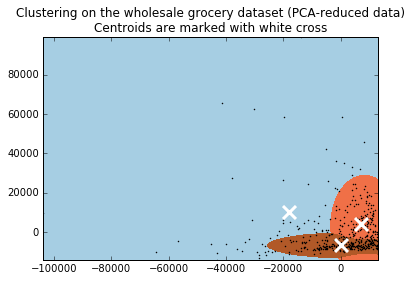

In [10]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')


plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
#plt.xticks(())
#plt.yticks(())
plt.axis([x_min, x_max, y_min, y_max])
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

If we look at the first center, which corresponds to the right-most cluster, we'll see  that it has a significantly larger Grocery and Milk profile than the data mean, and a much larger Paper/Detergents profile as well.  It corresponds closely to the typical ordering profile of a Grocery / Supermarket store, which isn't surprising given that the cluster seems to be distributed along the direction of the second PCA component which was established to correspond to a Grocery store profile of orders as well.

The second center, corresponding to the bottom-most cluster, has about the same distribution amongst the different categories of orders as the mean.  It's representative of the typical big customer.

The third center is difficult to categorize as a center, since the cluster itself seems to consist mostly of outlier points that don't neatly belong in either of the first two clusters.  However, upon inspection, it has a very high Fresh and Frozen ratio, so it's possible to interpret the third center as being the typical restaurant customer.

###Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

I feel that, in conjunction with more domain knowledge and more knowledge of the data and where it comes from, these techniques would have been much more useful.  But as is, I'm confronted mostly with numbers and six inprecise labels. Out of all the techniques used here, I would say clustering was the least useful since it revealed very little and since the data didn't divide that neatly into clusters.

The interpretations given for the ICA component vectors are a bit tenuous, but it seems like it was the most promising out of all of them.  With greater access to information regarding the origin of the data, it may have been possible to determine with greater accuracy what the ICA components actually correspond to.  However, as is, the ICA analysis did prove somewhat useful.  From our analysis, it seems that grocery stores/supermarkets, hotels, restaurants, delicatessens are among the company's customers. Although the identities of the customers behind the ICA components is part conjecture, the conjectures involved are at least plausible, and with greater future data that might identify customers, or with possible investigation of groups of customers, even more light can be shed on what the ICA components actually correspond to.

**9)** How would you use that technique to help the company design new experiments?

**10)** How would you use that data to help you predict future customer needs?

Answer: 